 # Training on CIFAR

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from sklearn import metrics

from deepee import UniformDataLoader


 Let's set up our configuration and dataset

In [2]:
class args:
    batch_size = 32
    test_batch_size = 200
    lr = 1e-3
    num_epochs = 5
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_interval = 100



In [3]:
# we need this for pytorch reasons -.-
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)



In [4]:
cifar10_stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
cifar100_stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
trainset = datasets.CIFAR10(
    "./data/CIFAR/",
    train=True,
    download=True,
)
L_train = round(0.85 * len(trainset))
trainset, valset = torch.utils.data.random_split(
    trainset,
    (L_train, len(trainset) - L_train),
    generator=torch.Generator().manual_seed(42),
)
trainset = DatasetFromSubset(
    trainset,
    transform=transforms.Compose(
        [
            # transforms.RandomAffine(180, translate=(0.25,0.25), scale=(0.7,1.3), shear=(20)),
            transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
            transforms.ToTensor(),
            transforms.Normalize(*cifar10_stats),
        ]
    ),
)
valset = DatasetFromSubset(
    valset,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(*cifar10_stats),
        ]
    ),
)
testset = datasets.CIFAR10(
    "./data/CIFAR/",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(*cifar10_stats),
        ]
    ),
)
trainloader = UniformDataLoader(
    trainset,
    batch_size=args.batch_size,
    pin_memory=torch.cuda.is_available(),
    num_workers=0 if torch.cuda.is_available() else 32,
)
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=args.batch_size,
    pin_memory=torch.cuda.is_available(),
    num_workers=0 if torch.cuda.is_available() else 32,
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=args.batch_size,
    pin_memory=torch.cuda.is_available(),
    num_workers=0 if torch.cuda.is_available() else 32,
    shuffle=False,
)


Files already downloaded and verified
Files already downloaded and verified


 ### lets have a look at the images


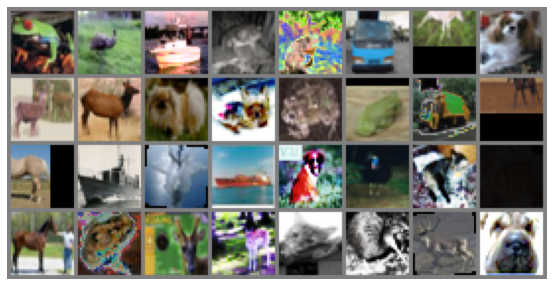

In [5]:
img_batch = torch.stack([trainset[i][0] for i in range(32)])
grid_img = make_grid(img_batch, nrow=8)
grid_img = (grid_img - torch.min(grid_img)) / (
    torch.max(grid_img) - torch.min(grid_img)
)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.show()



In [6]:
class CustomResNet18(torch.nn.Module):
    def __init__(self, num_classes=10, *args, **kwargs):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(*args, **kwargs)
        self.model.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)


def test(model, dataloader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    for data, target in dataloader:
        data, target = data.to(args.device), target.to(args.device)
        pred = model(data)
        loss = loss_fn(pred, target)
        total_loss += loss.cpu().detach().item()
        preds.extend(pred.cpu().detach().argmax(dim=1).tolist())
        targets.extend(target.cpu().detach().tolist())
    return total_loss / len(dataloader), (preds, targets)



In [7]:
nonprivate_model = CustomResNet18(num_classes=10, pretrained=True)
nonprivate_model.to(args.device)
nonprivate_optim = torch.optim.SGD(nonprivate_model.parameters(), lr=args.lr)
loss_fn = torch.nn.CrossEntropyLoss()


 ## Train the network in a classical non-private fashion

In [8]:
for epoch in range(args.num_epochs):
    nonprivate_model.train()
    print(f"Train epoch {epoch}")
    for batch_idx, (data, target) in enumerate(trainloader):
        nonprivate_optim.zero_grad()
        data, target = data.to(args.device), target.to(args.device)
        pred = nonprivate_model(data)
        loss = loss_fn(pred, target)
        loss.backward()
        nonprivate_optim.step()
        if batch_idx % args.log_interval == 0:
            print(f"\tBatch: {batch_idx}\tLoss: {loss.item():.2f}")

    val_loss, (preds, targets) = test(nonprivate_model, valloader)
    print(
        f"Validation epoch {epoch}\tVal loss: {val_loss:.2f}\tMCC: {metrics.matthews_corrcoef(targets, preds)*100.0:.2f}%\tAccuracy: {metrics.accuracy_score(preds, targets)*100.0:.2f}%"
    )


Train epoch 0
	Batch: 0	Loss: 2.40
	Batch: 100	Loss: 2.19
	Batch: 200	Loss: 2.15
	Batch: 300	Loss: 1.94
	Batch: 400	Loss: 1.50
	Batch: 500	Loss: 1.52
	Batch: 600	Loss: 1.77
	Batch: 700	Loss: 1.86
	Batch: 800	Loss: 1.52
	Batch: 900	Loss: 1.37
	Batch: 1000	Loss: 1.34
	Batch: 1100	Loss: 1.67
	Batch: 1200	Loss: 1.18
	Batch: 1300	Loss: 1.45
Validation epoch 0	Val loss: 1.18	MCC: 54.02%	Accuracy: 58.55%
Train epoch 1
	Batch: 0	Loss: 1.29
	Batch: 100	Loss: 1.52
	Batch: 200	Loss: 1.40
	Batch: 300	Loss: 1.74
	Batch: 400	Loss: 1.36
	Batch: 500	Loss: 1.39
	Batch: 600	Loss: 1.12
	Batch: 700	Loss: 1.17
	Batch: 800	Loss: 1.43
	Batch: 900	Loss: 1.56
	Batch: 1000	Loss: 1.20
	Batch: 1100	Loss: 1.24
	Batch: 1200	Loss: 1.32
	Batch: 1300	Loss: 1.28
Validation epoch 1	Val loss: 0.97	MCC: 62.00%	Accuracy: 65.77%
Train epoch 2
	Batch: 0	Loss: 1.42
	Batch: 100	Loss: 1.46
	Batch: 200	Loss: 1.40
	Batch: 300	Loss: 0.91
	Batch: 400	Loss: 1.31
	Batch: 500	Loss: 0.97
	Batch: 600	Loss: 1.17
	Batch: 700	Loss: 0.91
	B

 ## Now let's do the same thing again but this time privately

In [9]:
from deepee.watchdog import PrivacyWatchdog
from deepee import PrivacyWrapper
from deepee import ModelSurgeon, SurgicalProcedures



In [10]:
# set the learning rate for DP training
args.lr = 1e-3


In [11]:
private_model = CustomResNet18(num_classes=10, pretrained=True)
surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
surgeon.operate(private_model)
watchdog = PrivacyWatchdog(
    trainloader,
    target_epsilon=10.0,
    abort=True,
    target_delta=1e-5,
    report_every_n_steps=1,
)
private_model = PrivacyWrapper(
    private_model,
    args.batch_size,
    1.0,
    1e-3,
    watchdog=watchdog,
).to(args.device)
private_optim = torch.optim.SGD(private_model.wrapped_model.parameters(), lr=args.lr)


# ## Train the network in a privately


In [12]:
for epoch in range(args.num_epochs):
    private_model.train()
    print(f"Train epoch {epoch}")
    for batch_idx, (data, target) in enumerate(trainloader):
        private_optim.zero_grad()
        data, target = data.to(args.device), target.to(args.device)
        pred = private_model(data)
        loss = loss_fn(pred, target)
        loss.backward()
        private_model.clip_and_accumulate()
        private_model.noise_gradient()
        private_optim.step()
        if batch_idx % args.log_interval == 0:
            print(
                f"\tBatch: {batch_idx}\tLoss: {loss.item():.2f}"  # \tSpent privacy: {watchdog.inform():.2f}"
            )

    val_loss, (preds, targets) = test(private_model, valloader)
    print(
        f"Validation epoch {epoch}\tVal loss: {val_loss:.2f}\tMCC: {metrics.matthews_corrcoef(targets, preds)*100.0:.2f}%\tAccuracy: {metrics.accuracy_score(preds, targets)*100.0:.2f}%"
    )


Train epoch 0
	Batch: 0	Loss: 2.66
	Batch: 100	Loss: 2.80
	Batch: 200	Loss: 2.37
	Batch: 300	Loss: 2.50
	Batch: 400	Loss: 2.39
	Batch: 500	Loss: 2.44
	Batch: 600	Loss: 2.55
	Batch: 700	Loss: 2.55
	Batch: 800	Loss: 2.68
	Batch: 900	Loss: 2.37
	Batch: 1000	Loss: 2.44
	Batch: 1100	Loss: 2.46
	Batch: 1200	Loss: 2.59
	Batch: 1300	Loss: 2.60
/home/alex/anaconda3/envs/deepee2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
Validation epoch 0	Val loss: 5.06	MCC: 0.00%	Accuracy: 9.97%
Train epoch 1
	Batch: 0	Loss: 2.41
	Batch: 100	Loss: 2.46
	Batch: 200	Loss: 2.50
	Batch: 300	Loss: 2.36
	Batch: 400	Loss: 2.41
	Batch: 500	Loss: 2.50
	Batch: 600	Loss: 2.61
	Batch: 700	Loss: 2.58
	Batch: 800	Loss: 2.56
	Batch: 900	Loss: 2.79
	Batch: 1000	Loss: 2.67
	Batch: 1100	Loss: 2.27
	Batch: 1200	Loss: 2.52
	Batch: 1300	Loss: 2.39
/home/alex/anaconda3/envs/deepee2/lib/python3.9/site-

In [13]:
test_loss_nonprivate, (preds_nonprivate, targets_nonprivate) = test(
    nonprivate_model, testloader
)
test_loss_private, (preds_private, targets_private) = test(private_model, testloader)
print(
    f"[Non-private] Test loss: {test_loss_nonprivate:.2f}\tMCC: {metrics.matthews_corrcoef(targets_nonprivate, preds_nonprivate)*100.0:.2f}%\tAccuracy: {metrics.accuracy_score(preds_nonprivate, targets_nonprivate)*100.0:.2f}%"
)
print(
    f"[Private] Test loss: {test_loss_private:.2f}\tMCC: {metrics.matthews_corrcoef(targets_private, preds_private)*100.0:.2f}%\tAccuracy: {metrics.accuracy_score(preds_private, targets_private)*100.0:.2f}%"
)

[Non-private] Test loss: 0.78	MCC: 70.21%	Accuracy: 73.17%
[Private] Test loss: 14.72	MCC: 0.00%	Accuracy: 10.00%
/home/alex/anaconda3/envs/deepee2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 # As we see private training doesn't learn shit and takes ages